In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib qt

Gradient decay
==========================================

Some results worth saving and displaying for visualization and understanding

1/ Decay of gradient variances with increasing qubit count
---------------------------

First importing the relevant packages

In [2]:
import sys
sys.path.append('../src')
sys.path.append('src')
import matplotlib.pyplot as plt
import numpy as np
from gadget_plots import *
from data_management import get_training_costs, get_training_labels2, get_training_info

data_folder = '../../results/data/'

colours = np.array([plt.cm.Purples(np.linspace(0, 1, 10)),          # global
                    plt.cm.Blues(np.linspace(0, 1, 10)),            # local
                    plt.cm.Oranges(np.linspace(0, 1, 10)),          # gadget2
                    plt.cm.Reds(np.linspace(0, 1, 10)),             # gadget3
                    plt.cm.Greys(np.linspace(0, 1, 10))])[:, 3:]    # legends

Exponential decay of the global Hamiltonian
$$H_G = \bigotimes_{i=1}^n \sigma_i^z $$

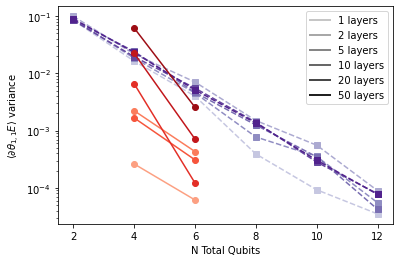

In [3]:
file_comp = data_folder + 'gradients/220707/gradients_nr0001.npz'
file_gad = data_folder + 'gradients/220707/gradients_nr0002.npz'
layers_list = [1, 2, 5, 10, 20, 50]

data = np.load(file_comp)
variances_list = data['variances_list']
norms_list = data['norms_list']
qubits_list = data['width_list']

fig, ax = plt.subplots()
for line in range(len(variances_list)):
    normalized_variances = variances_list[line]/norms_list**2
    ax.semilogy(qubits_list, normalized_variances, "--s", c=colours[0][line])

data = np.load(file_gad)
variances_list = data['variances_list']
norms_list = data['norms_list']
qubits_list = data['computational_qubits'][:2]

# ax2 = ax.twiny() 
for line in range(len(variances_list)):
    normalized_variances = variances_list[line]/norms_list**2
    ax.semilogy(qubits_list, normalized_variances, "-o", c=colours[3][line])

ax.set_xlabel(r"N Total Qubits")
ax.set_ylabel(r"$\langle \partial \theta_{1, 1} E\rangle$ variance")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# ax2.set_xlabel(r"N Total Qubits", color = 'grey') 
# ax2.tick_params(axis ='x', labelcolor = 'grey')
# ax2.xaxis.set_major_locator(MultipleLocator(2))

custom_lines = [Line2D([0], [0], color=colours[-1][nl], lw=2) for nl in range(len(layers_list))]
ax.legend(custom_lines, ['{} layers'.format(num_layers) for num_layers in layers_list])

Training
=======

3-local gadget decomposition
---------------------

In [13]:
def plot_single_training(file):
    plt.rcParams["figure.figsize"] = 5, 4
    costs = get_training_costs(file + '.npz')
    labels = get_training_labels2(file + '.txt')
    colors = plt.cm.rainbow(np.linspace(0, 1, len(costs)-1))
    fig, ax1 = plt.subplots()
    # ax2 = ax1.twinx()
    ax1.plot(np.ones(len(costs[0])), ':', c='gainsboro')
    ax1.plot(-np.ones(len(costs[0])), ':', c='gainsboro')
    ax1.plot(np.zeros(len(costs[0])), ':', c='gainsboro')
    for i in range(1, len(costs)):
        ax1.plot(costs[i],'-', c=colors[i-1], label=labels[i])
    ax1.plot(costs[0],':', c='grey', label='Training')
    ax1.legend()
    ax1.set_xlabel('iterations')
    ax1.set_ylabel('computational cost')
    print('Final training cost: {:4.8f}'.format(costs[0][-1]))

$\lambda = \lambda_{max}$

Final training cost: -0.00149808
Final training cost: 0.02143695
Final training cost: -0.00155758
Final training cost: -0.00277753


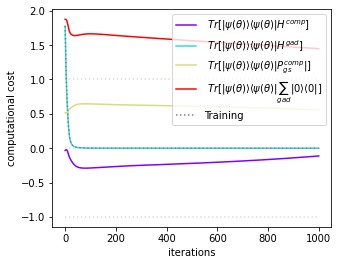

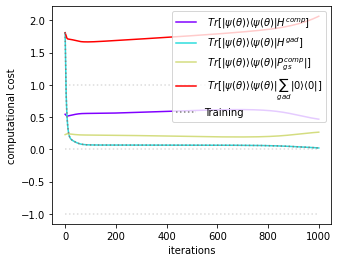

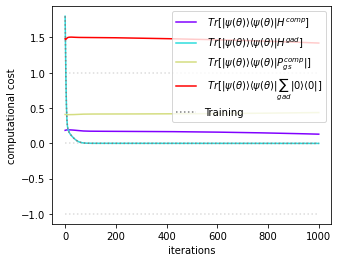

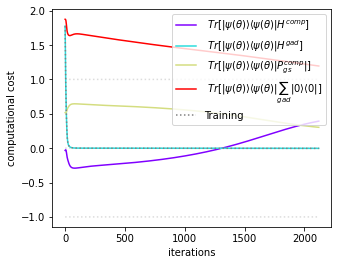

In [14]:
file_list = ['220707/training_nr0001', '220707/training_nr0002', 
             '220707/training_nr0003', '220707/training_nr0004']
for file in file_list:
    plot_single_training(data_folder + '/training/' + file)

$\lambda = 5\lambda_{max}$

Final training cost: -0.09814364
Final training cost: -0.13363876
Final training cost: -0.18677008
Final training cost: -0.14067912


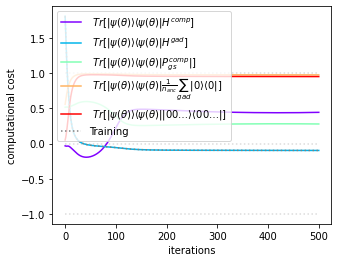

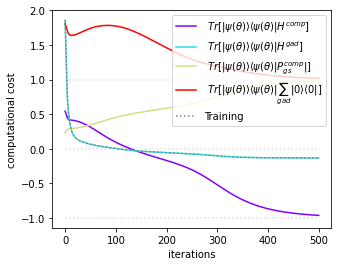

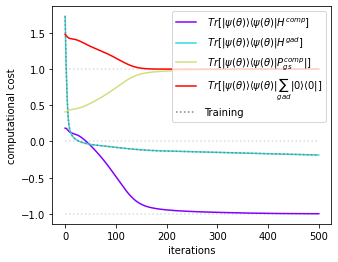

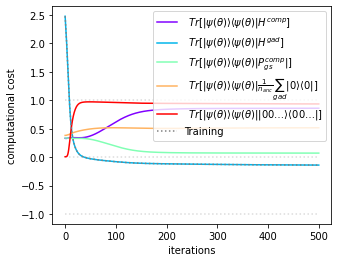

In [17]:
file_list = ['220708/training_nr0005', '220708/training_nr0002', 
             '220708/training_nr0003', '220708/training_nr0004']
for file in file_list:
    plot_single_training(data_folder + '/training/' + file)